In [1]:
import pickle

import numpy as np
from pymc3 import summary, traceplot

from sklearn.linear_model import LinearRegression

%matplotlib inline

scikit learn
===

In [2]:
LR = LinearRegression()

In [3]:
X = np.random.randn(1000, 10)

In [4]:
Y = np.random.randn(1000,)

In [5]:
LR.fit(X, Y)

/Users/nicole/sites/pydata_chicago_june_2017/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
X_predict = LR.predict(X)

In [7]:
LR.score(X, Y)

0.012611842656922612

In [8]:
pickle.dump(LR, open('LR.pickle', 'wb'))

In [9]:
saved_LR = pickle.load(open('LR.pickle', 'rb'))

In [10]:
saved_LR.score(X, Y)

0.012611842656922612

PyMC3
===

In [11]:
from ps_toolkit import HLM

In [12]:
HLM1 = HLM()

In [13]:
num_predictors = 5
num_samples = 500
num_categories = 3

In [14]:
fake_X = np.random.randn(num_samples, num_predictors)

In [15]:
fake_Y = np.random.randint(2, size=(num_samples,))

In [16]:
fake_cats = np.random.randint(num_categories, size=(num_samples,))

In [18]:
HLM1.fit(fake_X, fake_cats, fake_Y)

/Users/nicole/sites/pydata_chicago_june_2017/venv/lib/python2.7/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Average ELBO = -367.86: 100%|██████████| 50000/50000 [00:29<00:00, 1711.11it/s]
Finished minibatch ADVI: ELBO = -373.95
100%|██████████| 7500/7500 [00:00<00:00, 7996.48it/s]


HLM()

In [22]:
probs = HLM1.predict_proba(fake_X, fake_cats)

100%|██████████| 2000/2000 [00:08<00:00, 233.33it/s]


In [23]:
pred = HLM1.predict(fake_X, fake_cats)

100%|██████████| 2000/2000 [00:10<00:00, 196.52it/s]


In [24]:
HLM1.score(fake_X, fake_cats, fake_Y)

100%|██████████| 2000/2000 [00:09<00:00, 203.55it/s]


0.57999999999999996

In [25]:
HLM1.save("HLM_jar/")

In [26]:
HLM2 = HLM()

In [27]:
HLM2.load("HLM_jar/")

In [28]:
HLM2.score(fake_X, fake_cats, fake_Y)

100%|██████████| 2000/2000 [00:08<00:00, 239.89it/s]


0.57999999999999996

Bonus!
===

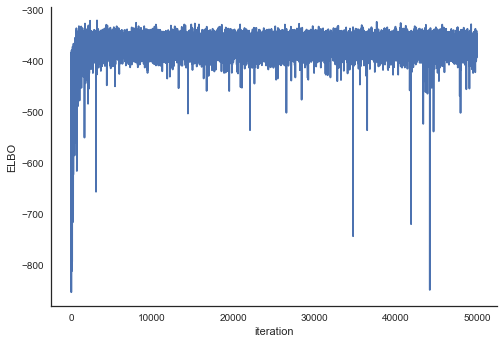

In [19]:
HLM1.plot_elbo()

In [20]:
summary(HLM1.advi_trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.036           0.203            0.002            [-0.445, 0.347]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.436         -0.172         -0.035         0.097          0.362


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.019           0.054            0.001            [-0.122, 0.086]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.124         -0.055         -0.019         0.017          0.086


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1151660d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11619f250>]], dtype=object)

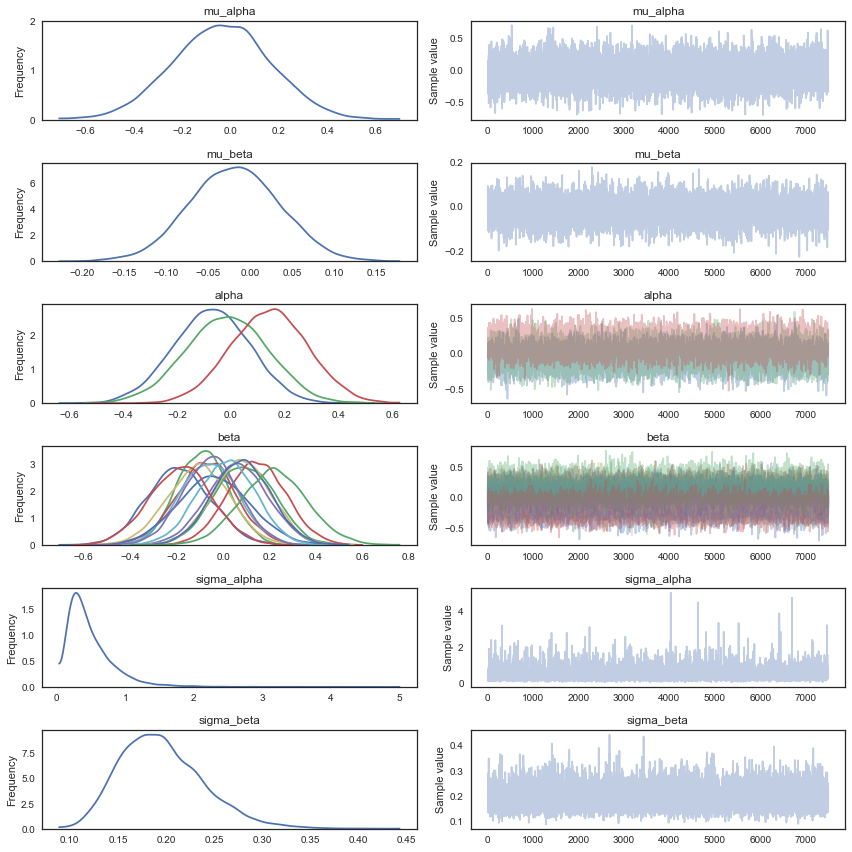

In [21]:
traceplot(HLM1.advi_trace)